# Model Training

This notebook shows how you can train the model. The code to perform following is avaliable in `src` folder

* load and transform data
* train model
* evaluate model

We can also train the models directly through shell using `python trainer.py --model vggbaseline --epochs 10`

Date: 03-Feb-2020

In [1]:
import sys
sys.path.insert(0, "../src/")
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tensorboardX import SummaryWriter

In [4]:
# Display library info
import PIL
import tensorboardX
print(f"Numpy: {np.__version__}")
print(f"PIL: {PIL.__version__}")
print(f"Torch: {torch.__version__}")
print(f"TensorboardX: {tensorboardX.__version__}")

Numpy: 1.17.3
PIL: 7.0.0
Torch: 1.4.0
TensorboardX: 2.0


In [5]:
# Load local classes and methods
from data import CCDataLoader, default_train_transforms, default_val_transforms, display_transforms
from models import VGG16Baseline, VGG16WithDecoderV2
from trainer import Trainer
from debug import load_predict_plot, display_loader, validate_dims

In [6]:
# Set seed
np.random.seed(42)
torch.manual_seed(42)
print(f"Is cuda available: {torch.cuda.is_available()}") 

Is cuda available: True


# Data
- Load data
- Apply transforms

In [7]:
# 1. Load data
data_dir = {
    "train": "/mnt/bigdrive/datasets/crowd-counting/C3Data/train_data/",
    "val": "/mnt/bigdrive/datasets/crowd-counting/C3Data/test_data/"
}

# We use 30 images to do a quick test run to ensure that model
# does not have any issues and is able to learn
train_fifty = [v for v in open("train_den50.txt", "r").read().split()]
val_fifty  = [v for v in open("val_den50.txt", "r").read().split()]
output_size = 224

loaders = {
    "train": CCDataLoader(
        data_dir["train"], default_train_transforms(output_size=output_size, factor=1), 
        num_workers=10, sample_images=train_fifty
    ),
    "val": CCDataLoader(
        data_dir["val"], default_val_transforms(output_size=output_size, factor=1), 
        num_workers=10, sample_images=val_fifty
    )
}

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print(f"Total images: {len(loaders['train'].ds)}")

Total images: 30


In [13]:
# debug.py includes methods to help debug things like: 
# checking the image,density size, displaying transformed images
validate_dims(loaders['train'].dataloader, VGG16Baseline(scale_factor=32), input_size=output_size)

img: torch.Size([3, 224, 224]), den: torch.Size([1, 224, 224]), output: torch.Size([224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img: (224, 224, 3), den: (1, 224, 224), count: 11.44


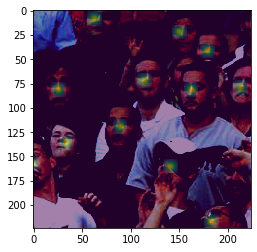

In [14]:
display_loader(loaders['train'].dataloader)

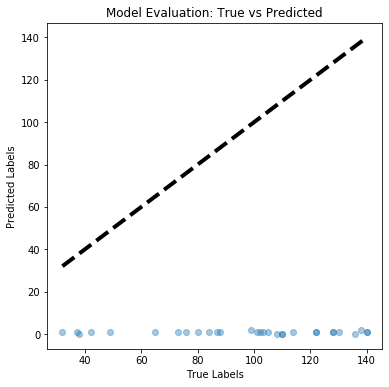

In [17]:
# Illustrate the performance on untrained model
plt = load_predict_plot(VGG16Baseline(), device, None, loaders["train"].ds.images)
plt.show()

The x-axis shows the actual/true labels and y-axis shows the labels predicted by our model. Since the model was initialised with random weights, we see that it is unable to get any where closer to actual label

# Model

Train the baseline model (VGG16Baseline) with 30 images in train_data and validate using test data. 

You can see the model train and val loss(MSE) in tensorboard. If you're running the training from the notebook then you'll need to run tensorboard inside notebooks directory.

In [15]:
# Model
model = VGG16Baseline(scale_factor=32) 
# Loss
criterion = nn.MSELoss()
# Optimizer
lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train
name = "vgg16baseline_100ep"
identifier = f"{name}-{lr}"
trainer = Trainer(loaders, model, criterion, optimizer, name=identifier)
model = trainer.train(100, writer_fname=identifier, tqdm_cls=tqdm)

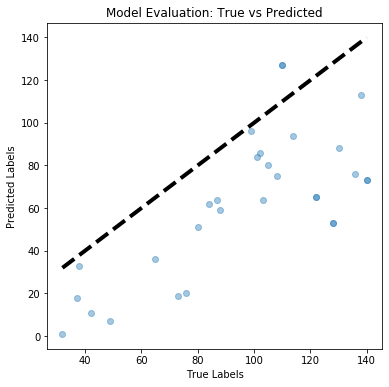

In [16]:
plt = load_predict_plot(model, device, None, loaders["train"].ds.images)
plt.show()

As you see, the model is able to learn something. The better the model learns, the more number of points start to lie along the diagonal line. But, in this example we just trained the model for 100 epochs and which is not enough. You should aim to train for atleast 300~600 epochs (use tensorboard to decide when to stop or better apply early stopping)

# VGG Decoder Model

You can similarly train other models. Althought it is important you pay attention to output_size and factor in default_xxx_transforms().

In [8]:
validate_dims(loaders['train'].dataloader, VGG16WithDecoderV2(), input_size=output_size)

img: torch.Size([3, 224, 224]), den: torch.Size([1, 224, 224]), output: torch.Size([224, 224])


In [11]:
# Model
model = VGG16WithDecoderV2() 
# Loss
criterion = nn.MSELoss()
# Optimizer
lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train
name = "vgg16withdecoder-50"
identifier = f"{name}-{lr}"
trainer = Trainer(loaders, model, criterion, optimizer, name=identifier)
model = trainer.train(300, writer_fname=identifier, tqdm_cls=tqdm)

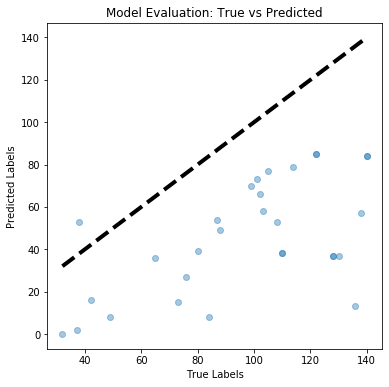

In [12]:
plt = load_predict_plot(model, device, None, loaders["train"].ds.images)
plt.show()

Okay, the test run works without the issue. Go ahead and train the full model.

---

Your turn 🚀. Good luck 👍